# __Prove of Concept__: try out Graph Neural Networks on trivial case, to prove its capabilities 

`Main idea:`
- <u>_Predictor variables_</u>: a dataset of points in the sample space (_N_DIM_ dimensions). We will reduce point's location information, by deleting one of the dimensions.
- <u>_Graph representation_</u>: a GNN will be provided with the graph, where nodes (representing our points) will be connected according to some distnce threshold (Euclidian distance).
- <u>_Target_</u>: arbitrary function in the given space, with several local minimums and the global one.
- <u>_Learning objective_</u>: derive targeted function.

The GNN will then overcome the missing dimensions data, by utilizing relationship information between points in the space.

In [53]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

## Data generation

In [54]:
space_dim = 2
n_missing_dim = 1
axis_range = 5
GRAIN = 0.1

n_samples = int((2 * axis_range / GRAIN) ** space_dim )
dim_bounds = [(-axis_range, axis_range) for _ in range(space_dim)]

In [55]:
dim_values = [
    np.arange(dim_min, dim_max, GRAIN)
    for dim_min, dim_max in dim_bounds    
]

grid = np.meshgrid(*dim_values)
points = np.stack([dim_matrix.flatten() for dim_matrix in grid], axis=-1)

print(points.shape)
points

(10000, 2)


array([[-5. , -5. ],
       [-4.9, -5. ],
       [-4.8, -5. ],
       ...,
       [ 4.7,  4.9],
       [ 4.8,  4.9],
       [ 4.9,  4.9]])

__Estimated function__ - [GRIEWANK function](https://www.sfu.ca/~ssurjano/griewank.html)

In [56]:
dim_idx = range(1, space_dim + 1)
target = (
    ((points ** 2).sum(axis=1) / 4000)
    - np.multiply(*np.cos(points / np.sqrt(dim_idx)).T)
    + 1
) * 100

target.shape

(10000,)

In [57]:
noise = stats.norm.rvs(loc=0, scale=6, size=target.shape)

In [58]:
def contour(ax: plt.Axes, data: np.ndarray) -> None:
    return ax.contourf(
        *dim_values,
        ( data ).reshape([
            int(2 * axis_range / GRAIN) for _ in range(space_dim)
        ])
    )

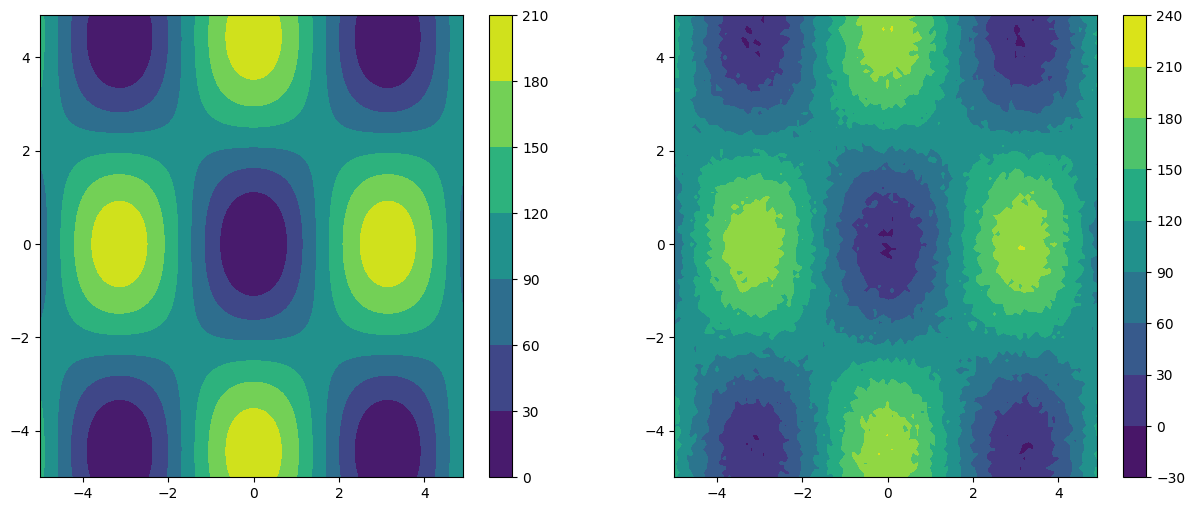

In [59]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 6)

fig.colorbar(contour(axs[0], target))
fig.colorbar(contour(axs[1], target + noise))

## Graph encoding

In [60]:
import sys
from pathlib import Path
import os

sys.path.append( (Path(os.getcwd()).parent).as_posix() )

In [61]:
def euclid_dist(a: np.ndarray, b: np.ndarray) -> float:
    return ((a - b) ** 2).sum()

In [62]:
import pickle
from importlib import reload
import src.encoders.graph_encoder as encoders

reload(encoders)
threshold_edges = encoders.threshold_edges

edge_index_cache = "cache/simple_edge_index.picke" 
if os.path.exists(edge_index_cache):
    with open(edge_index_cache, mode="rb") as f:
        edge_index = pickle.load(f)
else:
    edge_index = threshold_edges(points, euclid_dist, 0.3)
    with open(edge_index_cache, mode="wb") as f:
        pickle.dump(edge_index, f)

edge_index

tensor([[   0,  100,    0,  ..., 9998, 9997, 9998],
        [ 100,    0,  102,  ..., 9994, 9998, 9997]])

(array([  11.,   67.,  308.,  651., 1620., 3616., 2443., 1052.,  210.,
          21.]),
 array([ 4.        ,  8.19999981, 12.39999962, 16.60000038, 20.79999924,
        25.        , 29.20000076, 33.40000153, 37.59999847, 41.79999924,
        46.        ]),
 <BarContainer object of 10 artists>)

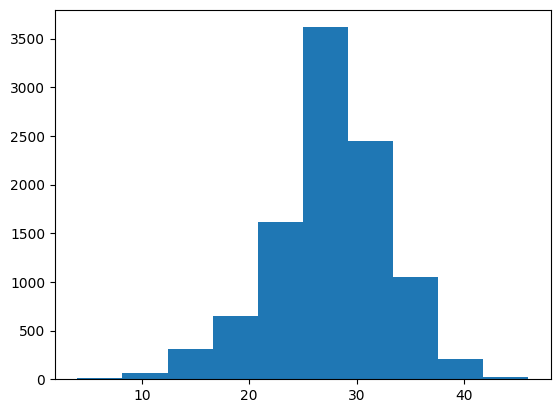

In [63]:
import torch_geometric.utils as utils

degrees = utils.degree(edge_index[0])
plt.hist(degrees)

In [64]:
import torch
from torch_geometric.data import Data

data = Data(
    torch.tensor(points[:, :-1], dtype=torch.float32),
    edge_index=edge_index,
    y=torch.tensor(( target + noise )[:, np.newaxis], dtype=torch.float32)
)

In [65]:
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.loader import NeighborLoader

node_splitter = RandomNodeSplit(num_test=0.2, num_val=0.1)
graph = node_splitter(data)

data_loader = NeighborLoader(
    graph,
    # batch_size=256,
    input_nodes=graph.train_mask,
    num_neighbors=[5] * 2,
    shuffle=True,
)

## Modelling

In [66]:
import torch.nn as nn
import torch_geometric.nn as nn_geom

class GNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        
        # self.conv1 = nn_geom.SAGEConv(input_size, hidden_size)

        self.lin_1 = nn.Linear(input_size, hidden_size)
        self.lin_2 = nn.Linear(hidden_size, hidden_size)
        self.lin_3 = nn.Linear(hidden_size, 1)


    def forward(self, data: Data, edge_index: torch.Tensor) -> torch.Tensor:
        # x = self.conv1(data, edge_index)

        x = self.lin_1(data).relu()
        x = self.lin_2(x).relu()
        return self.lin_3(x)

In [67]:
model = GNN(graph.num_features, 16)
loss_criteria = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=5e-4)

In [68]:
from sklearn.metrics import r2_score

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    for batch in data_loader:
        breakpoint()
        optim.zero_grad()
        out = model(batch.x, batch.edge_index)

        y = batch.y[:batch.batch_size]
        out = out[:batch.batch_size]
        loss = loss_criteria(out, y)

        loss.backward()
        optim.step()

    # if epoch % 10 == 0:
    model.eval()
    with torch.no_grad():
        predicts = model(graph.x, graph.edge_index)
        mse = loss_criteria(predicts[graph.val_mask], graph.y[graph.val_mask])
        r2 = r2_score(graph.y[graph.val_mask].detach(), predicts[graph.val_mask])#.detach())
        print(f'Epoch #{epoch} | Loss = {mse:.4e} | R^2 = {r2}')

Epoch #0 | Loss = 2.7446e+03 | R^2 = -0.05577648695327175
Epoch #1 | Loss = 2.6407e+03 | R^2 = -0.015797510766002887
Epoch #2 | Loss = 2.5931e+03 | R^2 = 0.002522657285475849
Epoch #3 | Loss = 2.5963e+03 | R^2 = 0.0012880680599279826
Epoch #4 | Loss = 2.5987e+03 | R^2 = 0.00035145811227776935
Epoch #5 | Loss = 2.6060e+03 | R^2 = -0.00243939606752841
Epoch #6 | Loss = 2.5899e+03 | R^2 = 0.003752206870604624
Epoch #7 | Loss = 2.5938e+03 | R^2 = 0.0022496929339277383
Epoch #8 | Loss = 2.6016e+03 | R^2 = -0.0007620063217943507
Epoch #9 | Loss = 2.6027e+03 | R^2 = -0.0011819252311371375
Epoch #10 | Loss = 2.6079e+03 | R^2 = -0.003181596033303258
Epoch #11 | Loss = 2.5987e+03 | R^2 = 0.00034661215647058263
Epoch #12 | Loss = 2.6327e+03 | R^2 = -0.01270834289676337
Epoch #13 | Loss = 2.6181e+03 | R^2 = -0.0071210244274244605
Epoch #14 | Loss = 2.6120e+03 | R^2 = -0.004777730693014792
Epoch #15 | Loss = 2.6179e+03 | R^2 = -0.007013309343117502
Epoch #16 | Loss = 2.6039e+03 | R^2 = -0.001633825

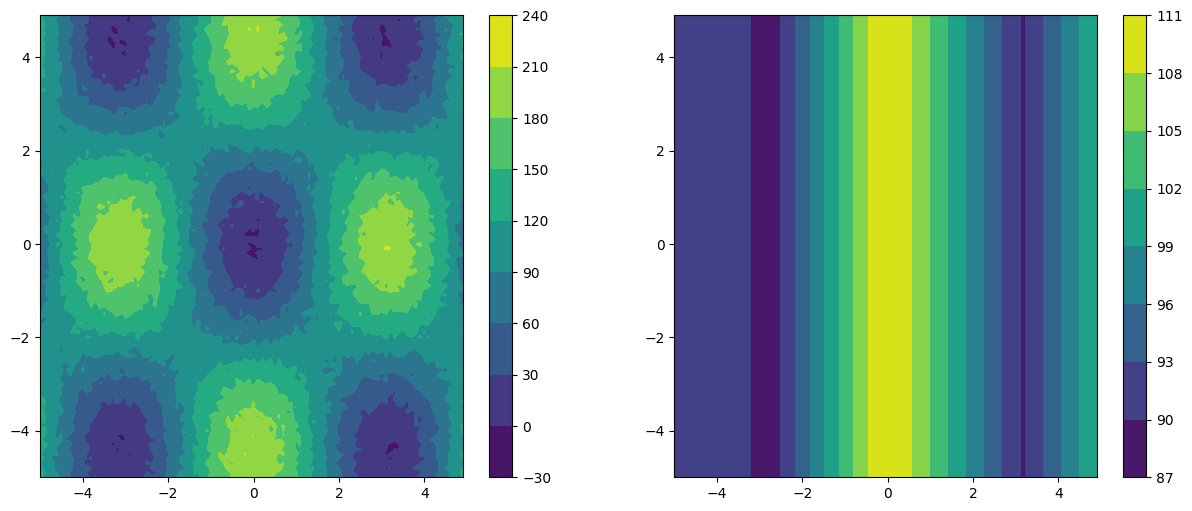

In [69]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 6)

fig.colorbar(contour(axs[0], target + noise))
fig.colorbar(contour(axs[1], model(graph.x, graph.edge_index).detach().flatten()))

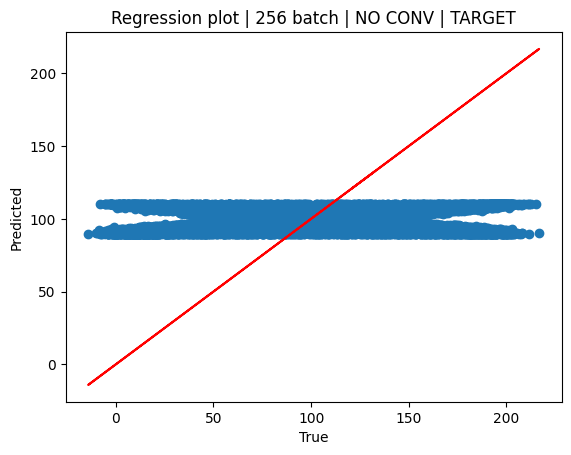

In [70]:
plt.title("Regression plot | 256 batch | NO CONV | TARGET")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.scatter(target + noise, model(graph.x, graph.edge_index).detach().numpy())
plt.plot(target + noise, target + noise, 'r-')

`CONV` 16x2 + relu

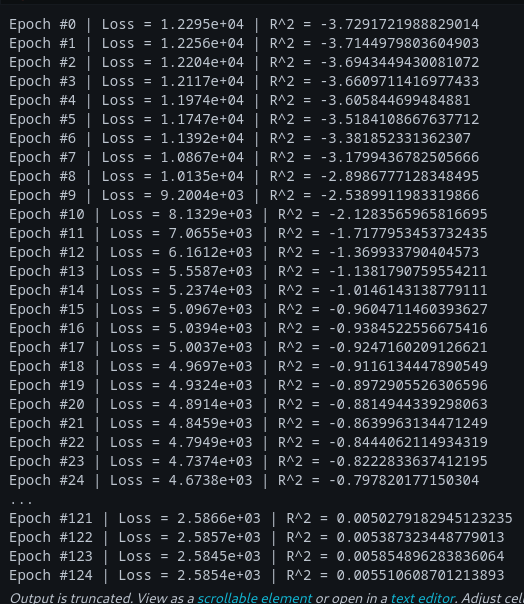